In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import ToTensor

from utils.dataset import VideoDataset
from utils.training import train_model
from utils.models import TrackNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

%load_ext autoreload
%autoreload 2

cuda


## Dataset

In [6]:
sequence_length = 3

dataset_params = dict(root="../videos/dataset_finales_2020_en/", image_size=(512, 512), sigma=5, sequence_length=sequence_length)

dataset_demo = VideoDataset(**dataset_params)
dataset_train = VideoDataset(**dataset_params, transform=ToTensor(), target_transform=ToTensor(), split='train')
dataset_val = VideoDataset(**dataset_params, transform=ToTensor(), target_transform=ToTensor(), split='val')

data_loader_train = DataLoader(dataset_train, batch_size=2)
data_loader_val = DataLoader(dataset_val, batch_size=2)

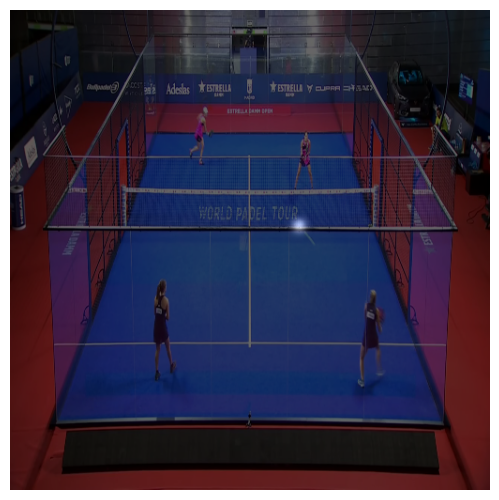

In [7]:
w, h, dpi = 480, 853, 100

fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)

frames, labels = dataset_demo[66]
ax.imshow(frames[0])
ax.imshow(labels[0], alpha=0.6, cmap='gray')
ax.set_axis_off()
fig.tight_layout(pad=0)

plt.show()

# Training

In [8]:
model = TrackNet(sequence_length=sequence_length)

In [ ]:
#TODO: check the loss function
#TODO: check the training recipe

checkpoint_folder = './checkpoints/checkpoints_512'

checkpoint_dict = train_model(model,
                              data_loader_train,
                              data_loader_val,
                              loss_function=F.mse_loss,
                              epochs=2,
                              device=device,
                              checkpoint_folder=checkpoint_folder)



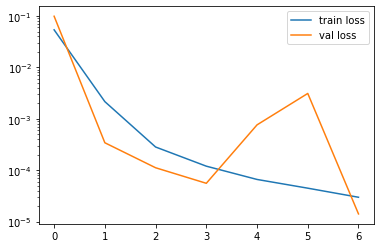

In [42]:
checkpoint_folder = './checkpoints/checkpoints_256'

train_loss = np.loadtxt(os.path.join(checkpoint_folder, "loss_history.csv"))
val_loss = np.loadtxt(os.path.join(checkpoint_folder, "loss_history_val.csv"))

fig, ax = plt.subplots()
ax.set_yscale('log')

ax.plot(train_loss, label='train loss')
ax.plot(val_loss, label='val loss')

ax.legend()

plt.show()

# Show example

Produce output heatmap

In [271]:
frames, heatmaps = dataset_val[2]
heatmaps_np = heatmaps.numpy()
frames_np = frames.numpy()[:3].transpose(1, 2, 0)

with torch.no_grad():
    outputs = model(frames[None, :].to(device))
outputs_np = outputs.to('cpu').numpy()[0].transpose(0, 2, 1)

Get maximum of the heatmap

In [272]:
def get_maximum_coordinates(heatmaps):
    if len(heatmaps.shape)==3:
        map_max_values = np.max(heatmaps.reshape(3, -1), axis=1)
        map_index = np.argmax(map_max_values)
        max_value = np.max(map_max_values)
        x, y = np.nonzero(heatmaps[map_index] == max_value)
    else:
        max_value = np.max(heatmaps)
        x, y = np.nonzero(heatmaps == max_value)

    return y[0], x[0]

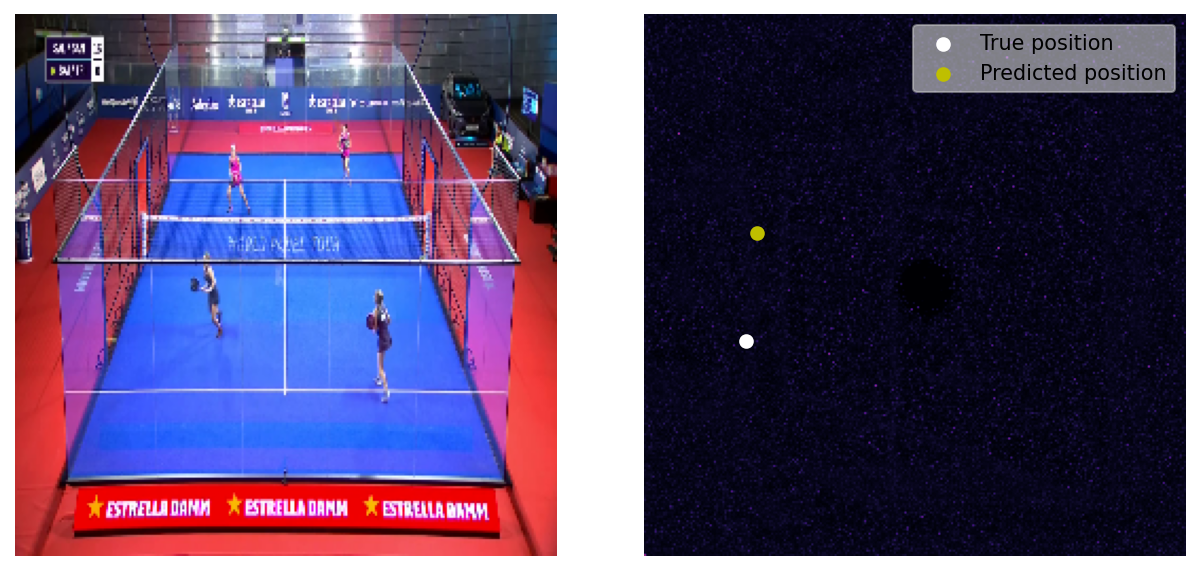

In [273]:
w, h, dpi = 1280, 720, 150

fig, axs = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi, ncols=2)

axs[0].imshow(frames_np)

axs[1].imshow(outputs_np[0], cmap='magma')
axs[1].scatter(*get_maximum_coordinates(heatmaps_np[0]), color='w', label='True position')
axs[1].scatter(*get_maximum_coordinates(outputs_np), color='y', label='Predicted position')

axs[1].legend(framealpha=0.5)

fig.tight_layout()
for ax in axs:
    ax.set_axis_off()

plt.show()

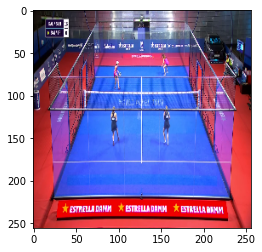

In [ ]:
plt.imshow(frames_np)

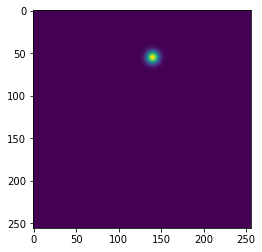

In [270]:
plt.imshow(heatmaps_np[0])
plt.show()

Find the maximum in the heatmap

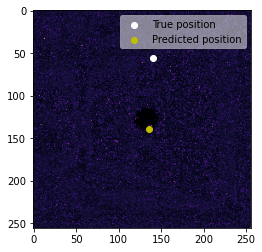

In [251]:
plt.imshow(outputs_np[0], cmap='magma')
plt.scatter(*get_maximum_coordinates(heatmaps_np[0]), color='w', label='True position')
plt.scatter(*get_maximum_coordinates(outputs_np), color='y', label='Predicted position')

plt.legend(framealpha=0.5)

plt.show()